Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 2ms/step
Episode: 929, Reward: 111.73923739705332
4/4 [==============================] - 0s 2ms/step
Episode: 930, Reward: 179.81974788105703
4/4 [==============================] - 0s 2ms/step
Episode: 931, Reward: 228.85526847932178
4/4 [==============================] - 0s 2ms/step
Episode: 932, Reward: 236.79643269239259
4/4 [==============================] - 0s 2ms/step
Episode: 933, Reward: 243.90812328328852
4/4 [==============================] - 0s 2ms/step
Episode: 934, Reward: -45.607526261381864
4/4 [==============================] - 0s 1ms/step
Episode: 935, Reward: 204.14054530020934
4/4 [==============================] - 0s 2ms/step
Episode: 936, Reward: 182.68129011595266
4/4 [==============================] - 0s 2ms/step
Episode: 937, Reward: -3.752345305800847
4/4 [==============================] - 0s 2ms/step
Episode: 938, Reward: 196.65680989580562
4/4 [=======================

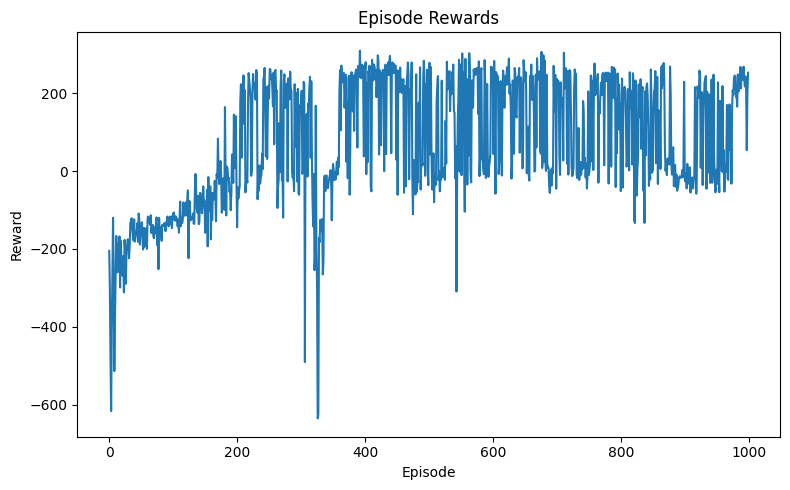

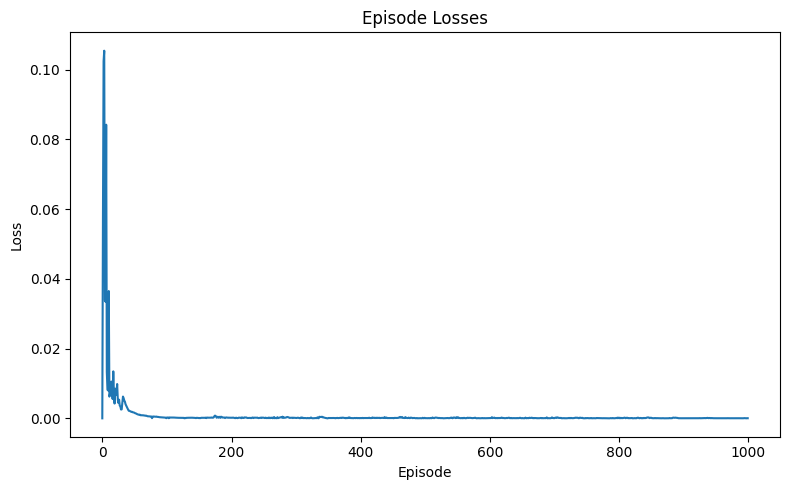

In [14]:
!apt-get update
!apt-get install -y ffmpeg

import os
os.environ['SDL_VIDEODRIVER'] = 'dummy'
os.environ['DISPLAY'] = ':0'

import gym
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
from gym.wrappers import RecordVideo


GAMMA = 0.99
BUFFER_SIZE = 10000
BATCH_SIZE = 128
LEARNING_RATE = 0.001
UPDATE_EVERY = 10
EXPLORATION_RATE_START = 1.0
EXPLORATION_RATE_END = 0.01
EXPLORATION_DECAY_RATE = 0.995
EPSILON_GREEDY_STEPS = 1000000

# Starting the environment
env = gym.make("LunarLander-v2")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n


replay_buffer = deque(maxlen=BUFFER_SIZE)

# Initializing the Q-Network
inputs = layers.Input(shape=(state_size,))
x = layers.Dense(128, activation="relu")(inputs)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(action_size, activation="linear")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=keras.losses.Huber())

# Initializing the target network
target_model = keras.models.clone_model(model)
target_model.set_weights(model.get_weights())

# Initializing the variables
steps = 0
exploration_rate = EXPLORATION_RATE_START
episode_rewards = []
episode_losses = []
successful_landings = 0

# Training the loop for 1000 episodes
num_episodes = 1000
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0
    episode_loss = 0
    done = False

    while not done:
        
        if np.random.rand() < exploration_rate:
            action = env.action_space.sample()  
        else:
            q_values = model(np.expand_dims(state, axis=0))
            action = np.argmax(q_values[0])  

        
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward

       
        replay_buffer.append((state, action, reward, next_state, done))

        
        if len(replay_buffer) >= BATCH_SIZE and steps % UPDATE_EVERY == 0:
            sample_batch = random.sample(replay_buffer, BATCH_SIZE)

            
            states = np.array([transition[0] for transition in sample_batch])
            actions = np.array([transition[1] for transition in sample_batch])
            rewards = np.array([transition[2] for transition in sample_batch])
            next_states = np.array([transition[3] for transition in sample_batch])
            dones = np.array([transition[4] for transition in sample_batch])

            
            next_q_values = target_model.predict(next_states)
            target_values = rewards + GAMMA * np.max(next_q_values, axis=1) * (1 - dones)

            # Updating the Q-Network
            with tf.GradientTape() as tape:
                q_values = model(states)
                one_hot_actions = tf.one_hot(actions, action_size)
                masked_q_values = tf.reduce_sum(one_hot_actions * q_values, axis=1)
                loss = tf.reduce_mean(keras.losses.Huber()(target_values, masked_q_values))

            episode_loss += loss
            grads = tape.gradient(loss, model.trainable_variables)
            model.optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Updating the target network
        if steps % (UPDATE_EVERY * 4) == 0:
            target_model.set_weights(model.get_weights())

        # Updating the exploration rate
        exploration_rate = max(EXPLORATION_RATE_END, exploration_rate * EXPLORATION_DECAY_RATE)

        state = next_state
        steps += 1

    episode_rewards.append(episode_reward)
    episode_losses.append(episode_loss / steps)

    if episode_reward > 200:  
        successful_landings += 1

    print(f"Episode: {episode}, Reward: {episode_reward}")

# Plotting the results
plt.figure(figsize=(8, 5))
plt.plot(episode_rewards)
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(episode_losses)
plt.title("Episode Losses")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

# Saving  the trained model
model.save("lunar_lander_model.keras")



In [13]:
!pip install opencv-python imageio
import cv2
import imageio

# Here we create a new environment
env = gym.make("LunarLander-v2")

# Here we Load the trained model weights
model.load_weights("lunar_lander_model.keras")

# Initializing the variables
episode_rewards = []

# Here we Rendering videos for the last 30 episodes
for episode in range(num_episodes - 30, num_episodes):
    state = env.reset()
    done = False
    frames = []
    episode_reward = 0
    while not done:
        q_values = model(np.expand_dims(state, axis=0))
        action = np.argmax(q_values[0])
        state, reward, done, _ = env.step(action)
        episode_reward += reward

        # Converting it to RGB format
        rgb_frame = env.render(mode='rgb_array')

        # Resizing the frame to be divisible by 16
        resized_frame = cv2.resize(rgb_frame, (608, 400))

        # Converting the frame to BGR format 
        bgr_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2BGR)

        # Append the frame to the list
        frames.append(bgr_frame)

    # here we save the frames as a video
    video_path = f"./videos/lunar_lander_episode_{episode}.mp4"
    imageio.mimsave(video_path, frames, fps=30)
    print(f"Video saved for episode {episode}: {video_path}")

   
    episode_rewards.append(episode_reward)

# Here we calculate average reward for the rendered episodes
average_reward = sum(episode_rewards) / len(episode_rewards)
print(f"Average Reward (last {len(episode_rewards)} episodes): {average_reward:.2f}")

# Closing the environment
env.close()

Video saved for episode 970: ./videos/lunar_lander_episode_970.mp4
Video saved for episode 971: ./videos/lunar_lander_episode_971.mp4
Video saved for episode 972: ./videos/lunar_lander_episode_972.mp4
Video saved for episode 973: ./videos/lunar_lander_episode_973.mp4
Video saved for episode 974: ./videos/lunar_lander_episode_974.mp4
Video saved for episode 975: ./videos/lunar_lander_episode_975.mp4
Video saved for episode 976: ./videos/lunar_lander_episode_976.mp4
Video saved for episode 977: ./videos/lunar_lander_episode_977.mp4
Video saved for episode 978: ./videos/lunar_lander_episode_978.mp4
Video saved for episode 979: ./videos/lunar_lander_episode_979.mp4
Video saved for episode 980: ./videos/lunar_lander_episode_980.mp4
Video saved for episode 981: ./videos/lunar_lander_episode_981.mp4
Video saved for episode 982: ./videos/lunar_lander_episode_982.mp4
Video saved for episode 983: ./videos/lunar_lander_episode_983.mp4
Video saved for episode 984: ./videos/lunar_lander_episode_984

In [1]:
!apt-get install -y swig
!pip install box2d-py==2.3.5
!pip install gym[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (888 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubunt